In [43]:
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
import statistics
from sklearn.base import clone
from collections import Counter
import seaborn as sns
import numpy as np

# Import the Data set

In [44]:
## Load the data
with open('../../data/ass2.pickle', 'rb') as f:
    data = pickle.load(f)

Example of a sample

In [45]:
## Example of train sample
df = pd.DataFrame(data['train'])
print(df.iloc[0])

f0        1
f1        0
f2        0
f3        0
f4        0
f5        0
f6        2
f7        1
f8        2
f9        2
f10       1
f11       0
f12       0
f13       0
f14       0
f15       0
f16       0
f17       0
f18       1
f19       0
f20       0
f21       0
f22       0
f23       0
f24       0
f25       0
f26       0
f27       0
f28       0
f29       0
f30       0
f31       0
f32       0
f33       0
f34       0
f35       0
f36       2
f37       0
f38       0
f39       0
f40       0
f41       0
target    2
Name: 51905, dtype: int64


Extract train, dev, test datasets (x and y)

In [46]:
## Get train dev test Xs and ys (X type is dataFrame and y type is Series)
df_train = data['train']
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

df_dev = data['dev']
X_dev = df_dev.iloc[:, :-1]
y_dev = df_dev.iloc[:, -1]

df_test = data['test']
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Preliminary data analysis

In [47]:
print(f"X_train shape: {X_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (40533, 42)
X_dev shape: (13512, 42)
X_test shape: (13512, 42)


In [48]:
# count the number of samples for each label in the train dataset
print(f"Distribution of labels in the train dataset, order from most common to least: {list(Counter(y_train).items())}")

Distribution of labels in the train dataset, order from most common to least: [(2, 26734), (1, 9882), (0, 3917)]


#### We can see that this is a classification problem and that the data is not balanced

In [49]:
# check samples values range
print(f"X_train values range: {X_train.min().min()} - {X_train.max().max()}")

X_train values range: 0 - 2


In [50]:
# check if there are missing values
print(f"Number of missing values in the train dataset: {X_train.isnull().sum().sum()}")

Number of missing values in the train dataset: 0


<Axes: >

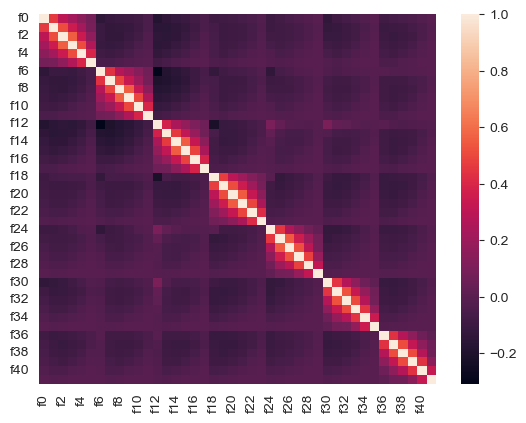

In [51]:
# check correlation between features
sns.heatmap(X_train.corr())
# TODO: what do we understand from this? maybe create a new correlation method

#### We can see that there is a high correlation between adjacent features

<Axes: >

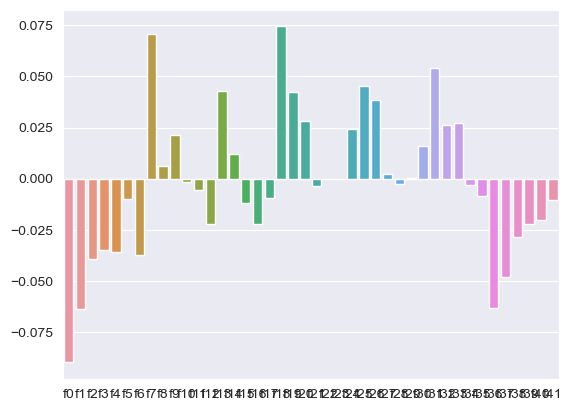

In [52]:
# show correlation between each feature and the label
all_correlations = []
for col in X_train.columns:
    corr = X_train[col].corr(y_train)
    all_correlations.append(corr)
# plot the correlation between each feature and the label

sns.barplot(x=X_train.columns, y=all_correlations)
# TODO: increase figure size

#### We can see that there is no direct correlation between a single feature and the label

array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f1'}>,
        <Axes: title={'center': 'f2'}>, <Axes: title={'center': 'f3'}>,
        <Axes: title={'center': 'f4'}>, <Axes: title={'center': 'f5'}>],
       [<Axes: title={'center': 'f6'}>, <Axes: title={'center': 'f7'}>,
        <Axes: title={'center': 'f8'}>, <Axes: title={'center': 'f9'}>,
        <Axes: title={'center': 'f10'}>, <Axes: title={'center': 'f11'}>],
       [<Axes: title={'center': 'f12'}>, <Axes: title={'center': 'f13'}>,
        <Axes: title={'center': 'f14'}>, <Axes: title={'center': 'f15'}>,
        <Axes: title={'center': 'f16'}>, <Axes: title={'center': 'f17'}>],
       [<Axes: title={'center': 'f18'}>, <Axes: title={'center': 'f19'}>,
        <Axes: title={'center': 'f20'}>, <Axes: title={'center': 'f21'}>,
        <Axes: title={'center': 'f22'}>, <Axes: title={'center': 'f23'}>],
       [<Axes: title={'center': 'f24'}>, <Axes: title={'center': 'f25'}>,
        <Axes: title={'center': 'f26'}>, <Ax

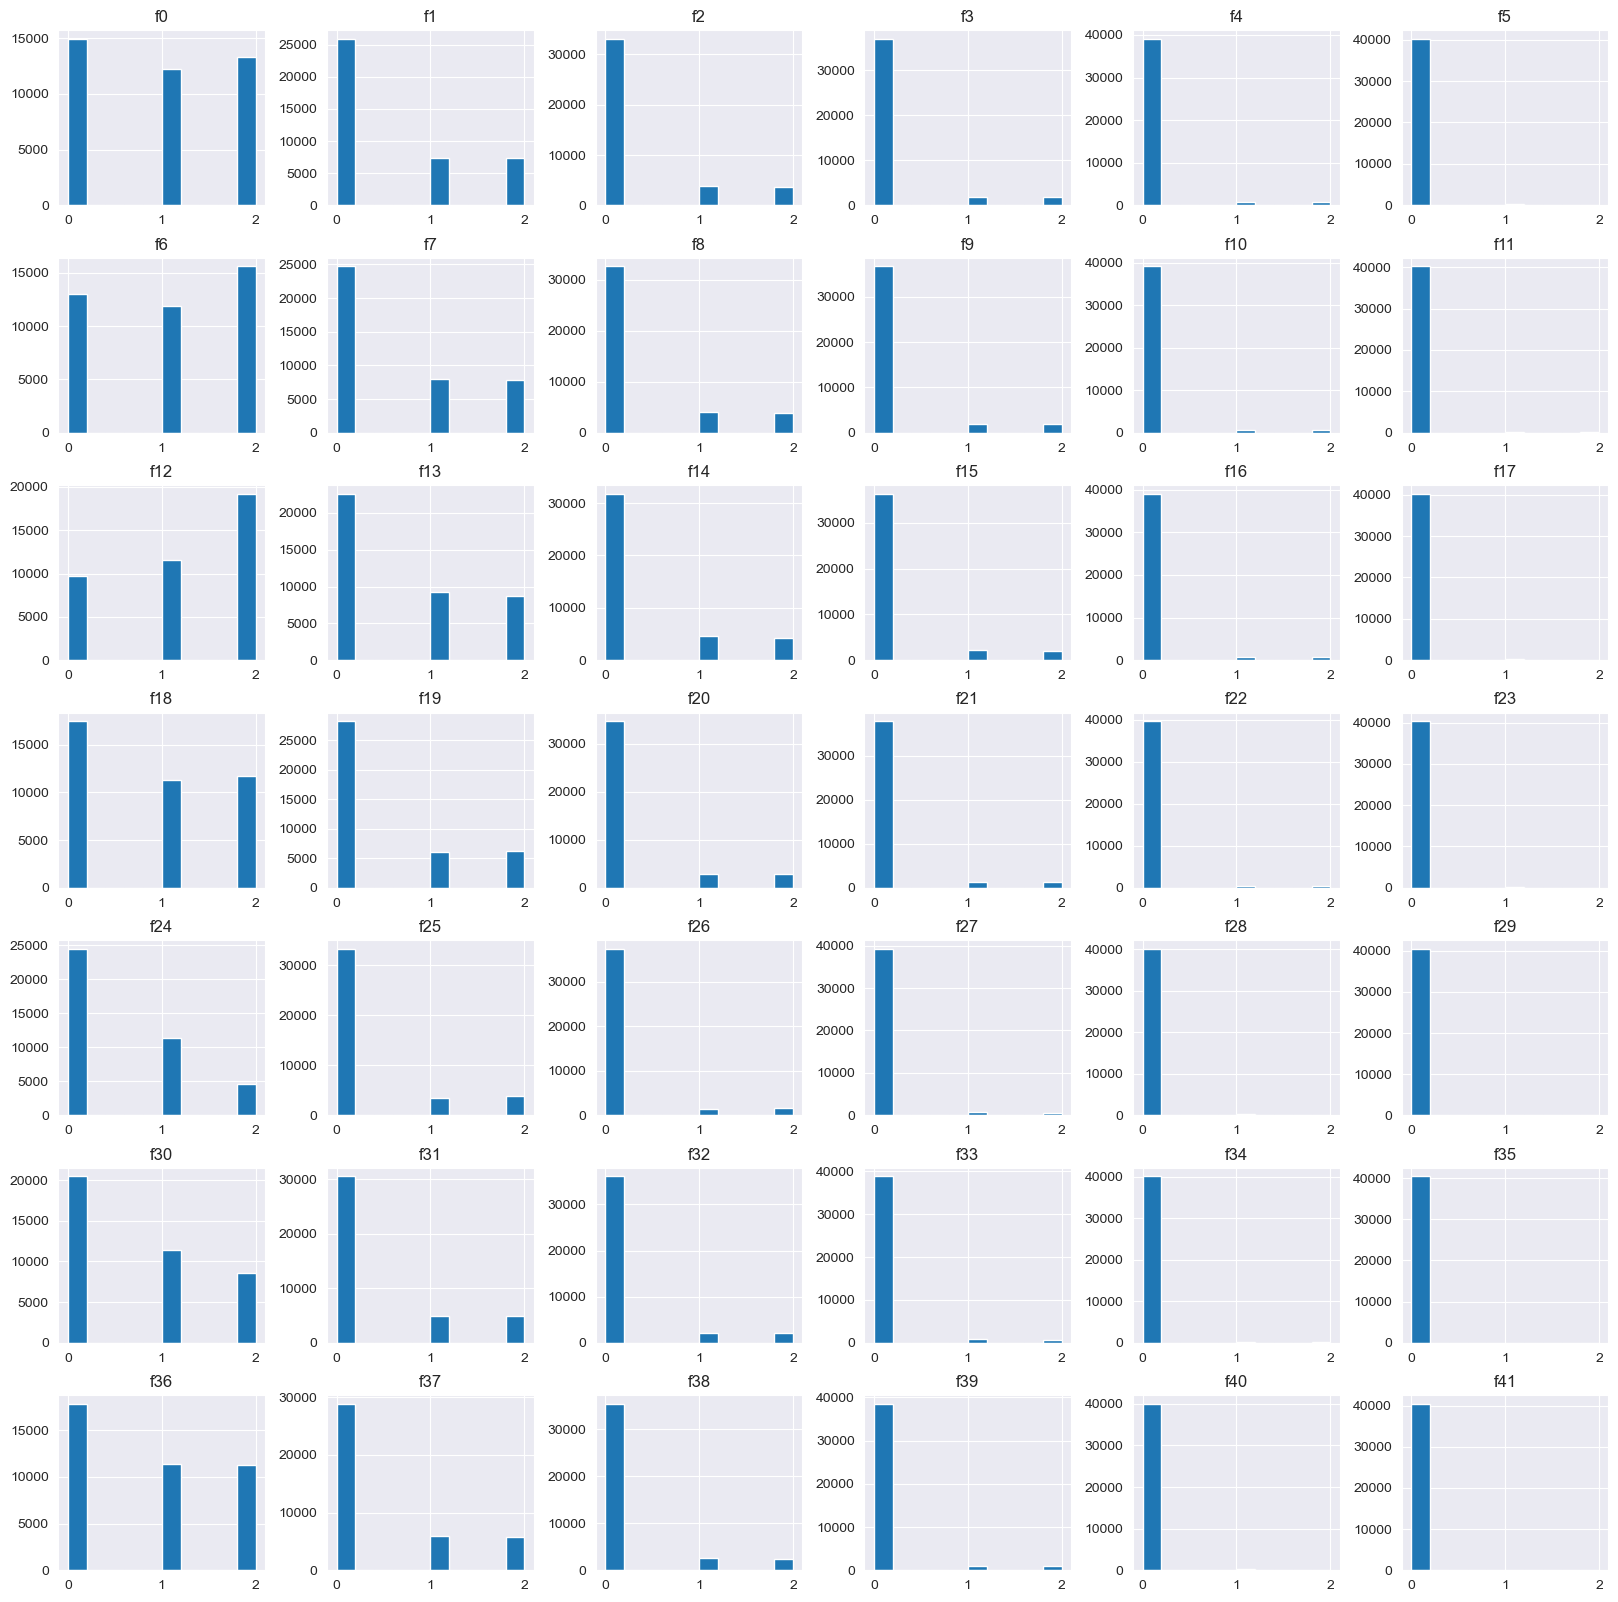

In [53]:
# show the distribution of the features
X_train.hist(figsize=(20, 20))
# TODO: what do we understand from this? i.e. f5 is always 0 maybe we can discard it?

# Preprocessing

In [54]:
# TODO: maybe reduce features that are almost always 0
# TODO: The dataset is unbalanced, we want to balance it without losing too much samples

# Models

Trying training the model with kfold method

In [55]:
## union dev and train datasets (for using in kfold)
print(X_train.shape)
print(X_dev.shape)
X_trainDev = pd.concat([X_train, X_dev], axis=0)
y_trainDev = pd.concat([y_train, y_dev], axis=0)

(40533, 42)
(13512, 42)


In [56]:
## defining a helper of kfold on train and dev datasets

def runKfold(model,X,y):
  kf = KFold(n_splits=5,shuffle=True)
  accs = []
  for train_index, test_index in kf.split(X.values):
      X_subtrain, X_subtest = X.values[train_index], X.values[test_index]
      y_subtrain, y_subtest = y.values[train_index], y.values[test_index]
      cloned_model = clone(model)
      cloned_model.fit(X_subtrain,y_subtrain)
      acc = accuracy_score(y_subtest, cloned_model.predict(X_subtest))
      accs.append(acc)
  mean_acc = statistics.mean(accs)
  print(f"Mean accuracy of {model} is {mean_acc}")
  return mean_acc


In [57]:
## function to try several models using kfold
def tryModelsKfold(models, X, y):
    all_accs = []
    for model in models:
        print(f"Trying model: {model}")
        acc = runKfold(model, X, y)
        all_accs.append(acc)
        print("_________________________________________________________")
    best_model = models[np.argmax(all_accs)]
    print(f"Best model: {best_model}")
    best_model.fit(X, y)
    return best_model

In [59]:
# trying several models using kfold
models = [
    DecisionTreeClassifier(),
    LogisticRegression(max_iter=10000),
    # GradientBoostingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier()
]
best_model = tryModelsKfold(models, X_trainDev, y_trainDev)
# check accuracy on test dataset
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset: {score}")

Trying model: DecisionTreeClassifier()
Mean accuracy of DecisionTreeClassifier() is 0.7257840688315293
_________________________________________________________
Trying model: LogisticRegression(max_iter=10000)
Mean accuracy of LogisticRegression(max_iter=10000) is 0.6611342399851975
_________________________________________________________
Trying model: RandomForestClassifier()
Mean accuracy of RandomForestClassifier() is 0.8100656860024054
_________________________________________________________
Trying model: AdaBoostClassifier()
Mean accuracy of AdaBoostClassifier() is 0.7279489314460172
_________________________________________________________
Trying model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importan

In [60]:
# trying several models using kfold and weights
# desicion tree with weights
models = [DecisionTreeClassifier(class_weight='balanced'), LogisticRegression(max_iter=10000, class_weight='balanced'), RandomForestClassifier(class_weight='balanced')]
# check accuracy on test dataset
best_model = tryModelsKfold(models, X_trainDev, y_trainDev)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset: {score}")


Trying model: DecisionTreeClassifier(class_weight='balanced')
Mean accuracy of DecisionTreeClassifier(class_weight='balanced') is 0.7312424831159219
_________________________________________________________
Trying model: LogisticRegression(class_weight='balanced', max_iter=10000)
Mean accuracy of LogisticRegression(class_weight='balanced', max_iter=10000) is 0.4453881025071699
_________________________________________________________
Trying model: RandomForestClassifier(class_weight='balanced')
Mean accuracy of RandomForestClassifier(class_weight='balanced') is 0.8080118419835323
_________________________________________________________
Best model: RandomForestClassifier(class_weight='balanced')
Accuracy on test dataset: 0.8129810538780343


In [65]:
# trying several models using kfold and weights
models = [xgb.XGBClassifier()]
# check accuracy on test dataset
best_model = tryModelsKfold(models, X_trainDev, y_trainDev)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset: {score}")

Trying model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Mean accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categoric